# Important Notes

* Notebook was redone to model on a larger dataset than the initial one on which this project was performed
* Changes still need to be made to allow certain algorithms to train and run in a feasible amount of time, given the newly large amount of data

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
# from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

In [12]:
pd.set_option('display.max_rows', 500)

# Import and Cleaning

In [3]:
df = pd.read_csv('final.csv', index_col = 0)

/Users/wasilaq/opt/anaconda3/envs/fdp/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
df['target_delay'] = df['arr_delay'].apply(lambda x: 1 if x > 15 else 0)
df = df[df['dest_weather_severity'] != 'UNK']
df = df[df['origin_weather_severity'] != 'UNK']
df.drop(columns = ['canceled', 'num_of_flights'], inplace = True)

In [5]:
df.columns

Index(['day_of_week', 'flight_date', 'reporting_airline', 'name',
       'tail_number', 'origin', 'origin_city', 'origin_statecode', 'dest',
       'dest_city', 'dest_statecode', 'dep_delay', 'arr_delay', 'diverted',
       'set_elapsed_time', 'actual_elapsed_time', 'miles', 'diverted_landings',
       'origin_timezone', 'dest_timezone', 'arrtime', 'deptime', 'set_arrtime',
       'set_deptime', 'dep', 'dep_utc', 'arr_utc', 'origin_weather_type',
       'origin_weather_severity', 'dest_weather_type', 'dest_weather_severity',
       'target_delay'],
      dtype='object')

In [6]:
df.head()

,day_of_week,flight_date,reporting_airline,name,tail_number,origin,origin_city,origin_statecode,dest,dest_city,...,set_arrtime,set_deptime,dep,dep_utc,arr_utc,origin_weather_type,origin_weather_severity,dest_weather_type,dest_weather_severity,target_delay
0,Monday,2019-04-01,NK,Spirit Air Lines,N605NK,BWI,"Baltimore, MD",MD,MCO,"Orlando, FL",...,12:12:00,10:10:00,2019-04-01 10:10:00,2019-04-01 15:10:00,2019-04-01 17:35:00,NaN,NaN,NaN,NaN,1
1,Monday,2019-04-08,NK,Spirit Air Lines,N904NK,BWI,"Baltimore, MD",MD,MCO,"Orlando, FL",...,12:12:00,10:10:00,2019-04-08 10:10:00,2019-04-08 15:10:00,2019-04-08 17:35:00,NaN,NaN,NaN,NaN,0
2,Monday,2019-04-15,NK,Spirit Air Lines,N637NK,BWI,"Baltimore, MD",MD,MCO,"Orlando, FL",...,12:12:00,10:10:00,2019-04-15 10:10:00,2019-04-15 15:10:00,2019-04-15 17:35:00,Storm,Severe,NaN,NaN,0
3,Monday,2019-04-22,NK,Spirit Air Lines,N619NK,BWI,"Baltimore, MD",MD,MCO,"Orlando, FL",...,12:12:00,10:10:00,2019-04-22 11:11:00,2019-04-22 16:11:00,2019-04-22 18:36:00,NaN,NaN,NaN,NaN,1
4,Monday,2019-04-29,NK,Spirit Air Lines,N644NK,BWI,"Baltimore, MD",MD,MCO,"Orlando, FL",...,12:12:00,10:10:00,2019-04-29 10:10:00,2019-04-29 15:10:00,2019-04-29 17:35:00,NaN,NaN,NaN,NaN,0


# EDA

Text(0.5, 1.0, 'Origin Weather')

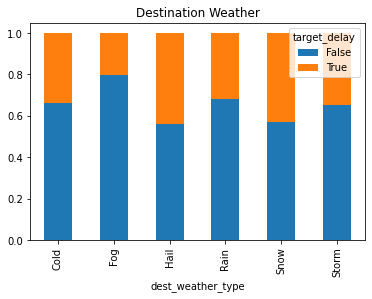

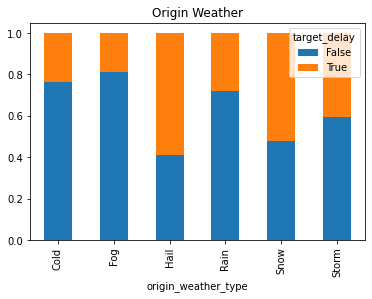

In [9]:
precipitation_del_d = pd.crosstab(df['dest_weather_type'], df['target_delay'].astype(bool))
precipitation_del_d.div(precipitation_del_d.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title("Destination Weather")

precipitation_del_o = pd.crosstab(df['origin_weather_type'], df['target_delay'].astype(bool))
precipitation_del_o.div(precipitation_del_o.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title("Origin Weather")

<AxesSubplot:xlabel='day_of_week'>

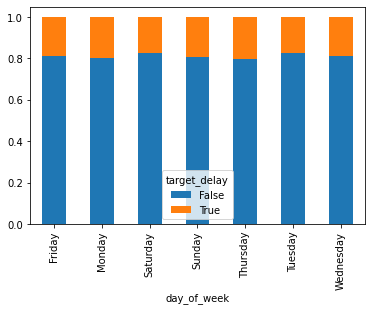

In [10]:
dayofwk_del = pd.crosstab(df['day_of_week'], df['target_delay'].astype(bool))
dayofwk_del.div(dayofwk_del.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

<AxesSubplot:xlabel='dest_statecode'>

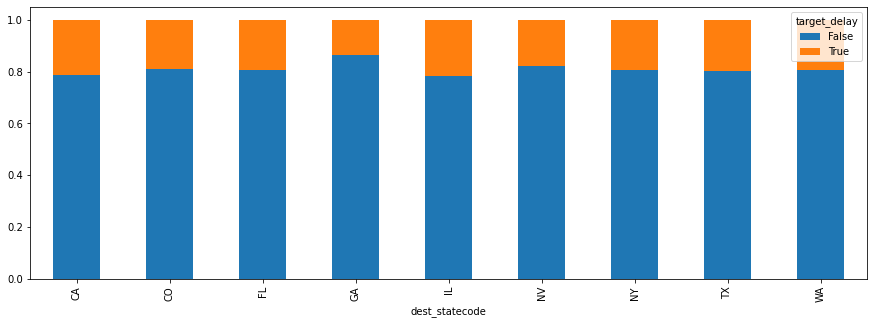

In [11]:
deststate_del = pd.crosstab(df['dest_statecode'],df['target_delay'].astype(bool))
deststate_del.div(deststate_del.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(15,5))

<AxesSubplot:xlabel='origin_statecode'>

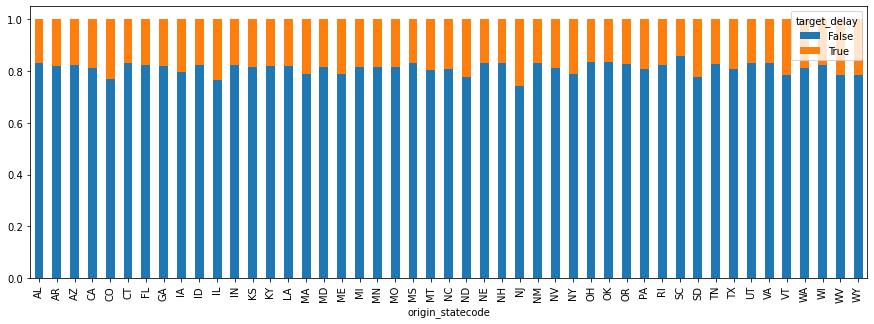

In [12]:
deststate_del = pd.crosstab(df['origin_statecode'], df['target_delay'].astype(bool))
deststate_del.div(deststate_del.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(15,5))

<AxesSubplot:xlabel='reporting_airline'>

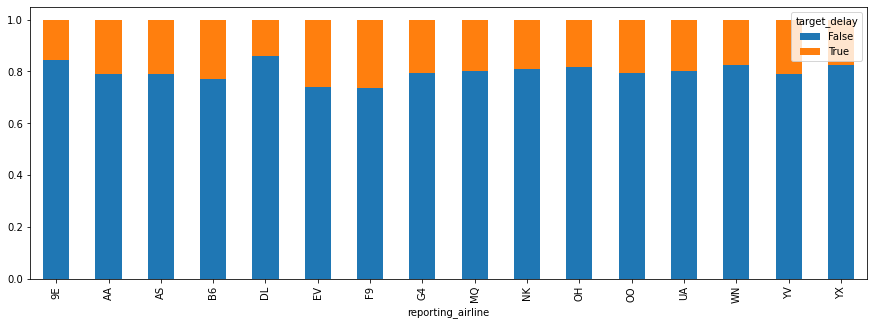

In [13]:
op_airline_del = pd.crosstab(df['reporting_airline'], df['target_delay'].astype(bool))
op_airline_del.div(op_airline_del.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, figsize=(15,5))

## Correlations

In [7]:
categorical = [
    'day_of_week', 'reporting_airline', 'origin_statecode', 'dest_statecode', 'origin_weather_type', 'origin_weather_severity', 'dest_weather_type', 'dest_weather_severity'
]

data_types = dict()

for x in categorical:
    data_types[x] = 'category' 

data_types['miles'] = 'uint16'
data_types['target_delay'] = 'uint8'
    
data = df.drop(
    columns = [
        'arrtime', 'set_arrtime', 'dep_utc', 'arr_utc', 'flight_date', 'name', 'tail_number', 'dep_delay', 'diverted', 'arr_delay', 'actual_elapsed_time', 'set_elapsed_time', 'origin', 'origin_city', 'dest', 'dest_city', 'deptime', 'set_deptime', 'dep', 'origin_timezone', 'dest_timezone', 'diverted_landings'
    ]
).astype(data_types)

In [15]:
data.columns

Index(['day_of_week', 'reporting_airline', 'origin_statecode',
       'dest_statecode', 'miles', 'origin_weather_type',
       'origin_weather_severity', 'dest_weather_type', 'dest_weather_severity',
       'target_delay'],
      dtype='object')

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2151070 entries, 0 to 2155433
Data columns (total 10 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   day_of_week              category
 1   reporting_airline        category
 2   origin_statecode         category
 3   dest_statecode           category
 4   miles                    uint16  
 5   origin_weather_type      category
 6   origin_weather_severity  category
 7   dest_weather_type        category
 8   dest_weather_severity    category
 9   target_delay             uint8   
dtypes: category(8), uint16(1), uint8(1)
memory usage: 39.0 MB


In [8]:
data2 = pd.get_dummies(data)

In [9]:
# standardize miles so that its between 0 and 1 like all other features
minimum = min(data2['miles'])
maximum = max(data2['miles'])

data2['miles'] = data2['miles'].apply(lambda x: (x - minimum)/(maximum - minimum))

In [15]:
# drop dummy variables, but keep all variables for weather (null values already dropped)

data2.drop(columns = ['day_of_week_Friday', 'reporting_airline_9E', 'origin_statecode_AL', 'dest_statecode_CA'], inplace = True)

In [16]:
list(data2.columns)

['miles',
 'target_delay',
 'day_of_week_Monday',
 'day_of_week_Saturday',
 'day_of_week_Sunday',
 'day_of_week_Thursday',
 'day_of_week_Tuesday',
 'day_of_week_Wednesday',
 'reporting_airline_AA',
 'reporting_airline_AS',
 'reporting_airline_B6',
 'reporting_airline_DL',
 'reporting_airline_EV',
 'reporting_airline_F9',
 'reporting_airline_G4',
 'reporting_airline_MQ',
 'reporting_airline_NK',
 'reporting_airline_OH',
 'reporting_airline_OO',
 'reporting_airline_UA',
 'reporting_airline_WN',
 'reporting_airline_YV',
 'reporting_airline_YX',
 'origin_statecode_AR',
 'origin_statecode_AZ',
 'origin_statecode_CA',
 'origin_statecode_CO',
 'origin_statecode_CT',
 'origin_statecode_FL',
 'origin_statecode_GA',
 'origin_statecode_IA',
 'origin_statecode_ID',
 'origin_statecode_IL',
 'origin_statecode_IN',
 'origin_statecode_KS',
 'origin_statecode_KY',
 'origin_statecode_LA',
 'origin_statecode_MA',
 'origin_statecode_MD',
 'origin_statecode_ME',
 'origin_statecode_MI',
 'origin_statecode_M

In [17]:
corr = data2.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

In [18]:
corr['target_delay'].sort_values()

dest_statecode_GA                  -0.064448
reporting_airline_DL               -0.062796
day_of_week_Tuesday                -0.015319
reporting_airline_WN               -0.014066
day_of_week_Saturday               -0.012873
origin_statecode_SC                -0.011815
origin_statecode_VA                -0.010443
origin_statecode_FL                -0.010156
origin_statecode_OH                -0.008953
origin_statecode_UT                -0.007631
dest_statecode_NV                  -0.007340
origin_statecode_OK                -0.006196
origin_statecode_TN                -0.006153
origin_statecode_AZ                -0.005841
origin_statecode_OR                -0.005476
origin_statecode_GA                -0.004825
origin_statecode_NM                -0.004301
origin_statecode_NE                -0.004035
reporting_airline_YX               -0.004019
origin_statecode_IN                -0.004008
origin_statecode_LA                -0.003399
origin_statecode_WI                -0.003277
origin_sta

<AxesSubplot:>

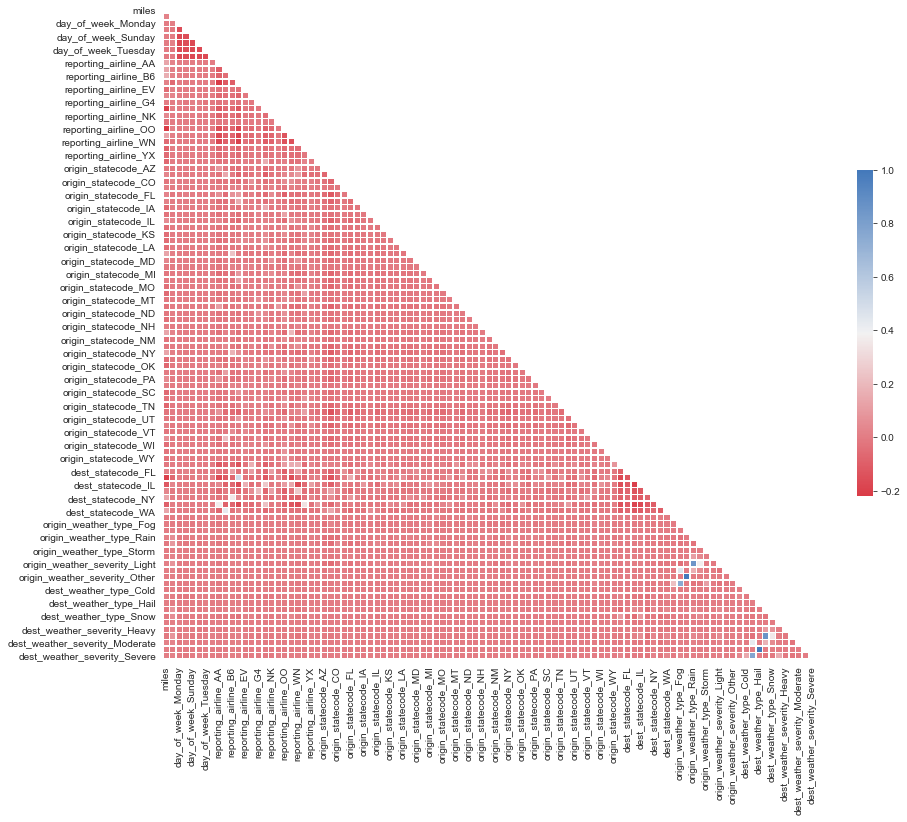

In [19]:
sns.set_style(style = 'white')
f, ax = plt.subplots(figsize=(15, 12))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

# Modeling

## Data Setup

In [21]:
X = data2.drop(columns = ['target_delay'])
y = data2['target_delay']

X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

### Class Imbalance

In [22]:
data2['target_delay'].value_counts()

0    1743790
1     407280
Name: target_delay, dtype: int64

In [34]:
RUS = RandomUnderSampler(sampling_strategy = 1, random_state=42) 

## Models

Using F1 score
* False positives and false negatives are equally important

### Dummy Classifier

In [35]:
dc = DummyClassifier()

pipeline = make_pipeline(RUS, dc)
cross_val_score(pipeline, X_tv, y_tv, cv=5, scoring='f1')

array([0., 0., 0., 0., 0.])

### Logistic Regression

#### Adjust Class Weights

In [36]:
lr = LogisticRegression(class_weight='balanced', max_iter=200)

In [37]:
cross_val_score(lr, X_tv, y_tv, cv=5, scoring='f1')

array([0.3349798 , 0.33585776, 0.33512887, 0.33566146, 0.33475327])

#### Oversampling

In [38]:
lr2 = LogisticRegression(max_iter=200)

In [39]:
pipeline = make_pipeline(RUS, lr2)
cross_val_score(pipeline, X_tv, y_tv, cv=5, scoring='f1')

array([0.33459844, 0.33551768, 0.33520688, 0.3351407 , 0.33520131])

*TO DO:*
* *plot F1 score against different probability thresholds*

Optimal method: **logistic regression with adjusted class weight & logistic regression with undersampling perform similarly**

### KNN

* KNN shows very slow performance given the amount of data. Unable to find optimal k value
* k = ~ square root of total samples

In [43]:
knn = KNeighborsClassifier(n_neighbors = 1400)
pipeline = make_pipeline(RUS, knn)
cross_val_score(pipeline, X_tv, y_tv, cv=5, scoring='f1')

KeyboardInterrupt: 

### Random Forest

* Random forest is slow to train

#### Adjust class weights

In [71]:
rfc = RandomForestClassifier(class_weight='balanced')

In [72]:
cross_val_score(rfc, X_tv, y_tv, cv = 5, scoring='f1')

KeyboardInterrupt: 

#### Oversampling

In [ ]:
rfc2 = RandomForestClassifier()

In [ ]:
cross_val_score(rfc2, X_tv_rs, y_tv_rs, cv = 5, scoring='f1')

*TO DO:*
* *SVM & naive bayes?*
* *grab smaller subset of data to optimize algorithms (namely, to find best hyperparameters for random forest and KNN) and test these additional models*

## Model Comparison

* Compare optimized models by using the ROC curve 

In [ ]:
cross_val_score(final_rfc, X_val, y_val, cv=5, scoring='roc_auc')

In [ ]:
final_lr = LogisticRegression(class_weight='balanced', max_iter=200)

cross_val_score(final_lr, X_val, y_val, cv=5, scoring='roc_auc')

Best model: 

# Final Performance

* Assign variable 'best' to best model

In [138]:
test_pred = best.predict(X_test)

In [ ]:
f1_score(y_test, test_pred)

In [ ]:
confusion_matrix(y_test, test_pred)

# Exporting Results

In [142]:
pred_prob = best.predict_proba(X_test)[:,1]

In [143]:
results = data2
results['prediction'] = test_pred
results['pred_prob_delay'] = pred_prob

In [149]:
results.to_csv('results.csv', index = False)